In [62]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### **Load the dataset**

In [63]:
# data_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
# data_dir = tf.keras.utils.get_file('cats_and_dogs.zip', origin= data_url, cache_dir= '.', extract= True)

In [64]:
PATH = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered')

# os.path.dirname(data_dir): Lấy thư mực chứa tệp zip đã tải về
# os.path.join(..., 'cats_and_dogs_filtered'): Tạo đường dẫn đến thư mục đã được giải nén
# Goal: để tạo đường dẫn trước để gọi ra tập training và test set

In [65]:
# Call out the training and test set had in the downloaded zip file
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Set the batch contains how many images first and the set the limit size for an image
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

### **Data Preprocessing**

#### Data download

In [66]:
# Split and shuffle the training and test dataset
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       shuffle = True,
                                                       batch_size = BATCH_SIZE,
                                                       image_size = IMG_SIZE)

validation_ds = tf.keras.utils.image_dataset_from_directory(test_dir, 
                                                     shuffle = True,
                                                     batch_size = BATCH_SIZE,
                                                     image_size = IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [67]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


#### Visualize some images

Here are some first images from training set:

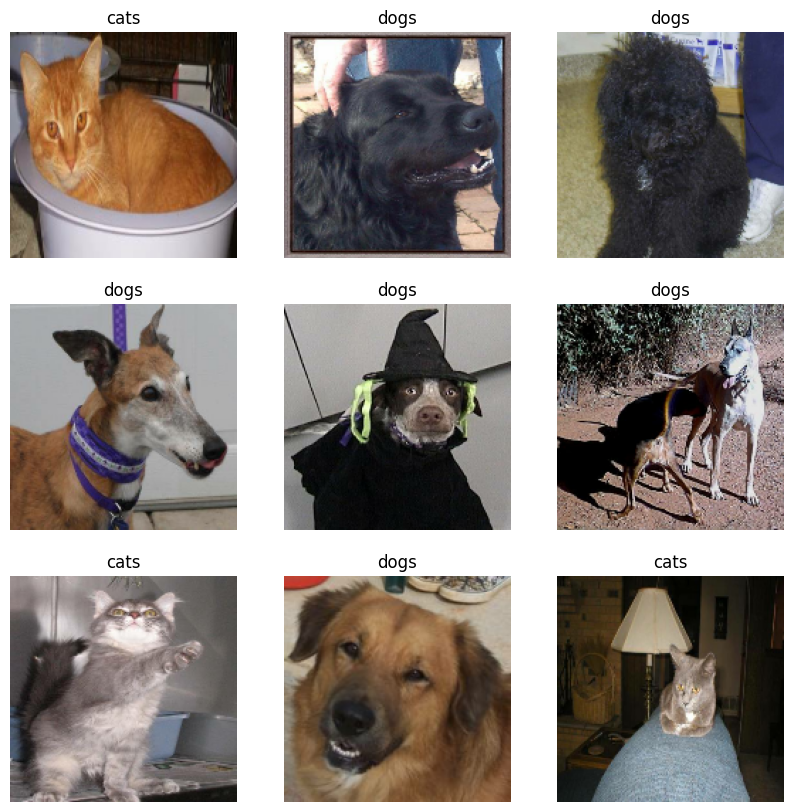

In [68]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [69]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 5) 
validation_ds = validation_ds.skip(val_batches // 5)

"""
    - .take ở đây đang là lấy ra 1/5 số batch từ validation_ds
    - .skip là bỏ qua 1/5 số batch đầu tiên và lấy còn lại 4/5 dữ liệu
    - tf.data.experimental.cardinality(validation_ds): trả về số lượng batch trong tập validation
    - Ta sẽ chia validation_ds thành 80% là validation và 20% cho test với mục đích là 
        + test set ở đây đóng vai trò là dữ liệu khi model training chưa từng thấy
        + validation set ở đây sẽ là dùng để điều chỉnh tham số, chọn mô hình tốt nhất.
    - Tập test đảm bảo kết quả tổng quan nhất trình overfitting khi chọn model.
"""

'\n    - .take ở đây đang là lấy ra 1/5 số batch từ validation_ds\n    - .skip là bỏ qua 1/5 số batch đầu tiên và lấy còn lại 4/5 dữ liệu\n    - tf.data.experimental.cardinality(validation_ds): trả về số lượng batch trong tập validation\n    - Ta sẽ chia validation_ds thành 80% là validation và 20% cho test với mục đích là \n        + test set ở đây đóng vai trò là dữ liệu khi model training chưa từng thấy\n        + validation set ở đây sẽ là dùng để điều chỉnh tham số, chọn mô hình tốt nhất.\n    - Tập test đảm bảo kết quả tổng quan nhất trình overfitting khi chọn model.\n'

In [71]:
print("Number of validation batches: %d" %tf.data.experimental.cardinality(validation_ds))
print("Number of test batches: %d" %tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


#### Configure the dataset for performance

In [72]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size= AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size= AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size= AUTOTUNE)

### **Build Model**

Build CNN model

In [79]:
num_classes = len(class_names)

model_cnn = Sequential([
    # cnn 
    layers.Rescaling(1./255, input_shape = (160, 160, 3)),
    layers.Conv2D(16, kernel_size= (3, 3), padding= 'same', activation= 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size= (3, 3), padding= 'same', activation= 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size= (3, 3), padding= 'same', activation= 'relu'),
    layers.MaxPooling2D(),
    
    # dense
    layers.Flatten(),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(1, activation= 'sigmoid')
])

model_cnn.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

model_cnn.fit(train_ds, validation_data= validation_ds, epochs= 10)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 261ms/step - accuracy: 0.4985 - loss: 0.8214 - val_accuracy: 0.4926 - val_loss: 0.6976
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.5439 - loss: 0.6845 - val_accuracy: 0.6646 - val_loss: 0.6089
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.6603 - loss: 0.6205 - val_accuracy: 0.7030 - val_loss: 0.5747
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.7017 - loss: 0.5567 - val_accuracy: 0.6906 - val_loss: 0.5896
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.7577 - loss: 0.4945 - val_accuracy: 0.6671 - val_loss: 0.6994
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.7910 - loss: 0.4464 - val_accuracy: 0.7054 - val_loss: 0.6261
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.8362 - loss: 0.3873 - val_accuracy: 0.7030 - val_loss: 0.6803
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.8689 - loss: 0.3149 - val_accu

**You can see that the result is overfitting when the accuracy on training set is very high but the accuracy on validation set is low.**

Using Data Augmentation to train model

In [82]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal',
                      input_shape = (160, 160, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

d:\Python Download\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


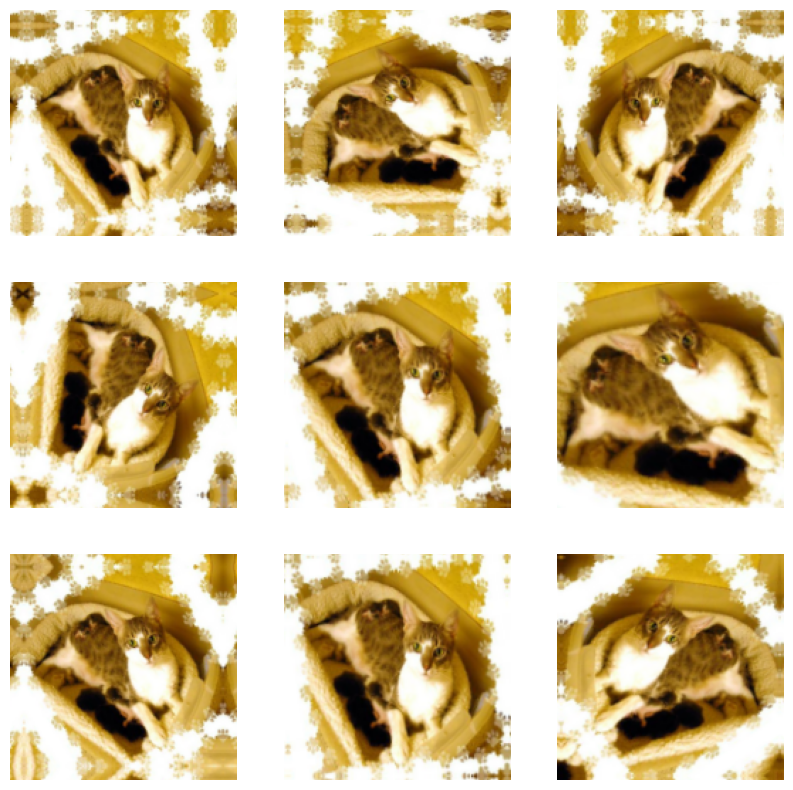

In [85]:
plt.figure(figsize= (10, 10))

for img, labels in train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(img)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_img[0].numpy().astype("uint8"))
        plt.axis("off")

In [86]:
model_data_aug = Sequential([
    # data augmentation
    data_augmentation,
    
    # cnn 
    layers.Rescaling(1./ 255),
    layers.Conv2D(16, kernel_size= (3, 3), padding= 'same', activation= 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size= (3, 3), padding= 'same', activation= 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size= (3, 3), padding= 'same', activation= 'relu'),
    layers.MaxPooling2D(),
    
    # dense
    layers.Flatten(),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(1, name= 'outputs')
])

model_data_aug.compile(optimizer = 'adam',
                       loss = tf.keras.losses.BinaryCrossentropy(from_logits= True),
                       metrics = ['accuracy'])

model_data_aug.fit(train_ds, validation_data = validation_ds, epochs = 15)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 398ms/step - accuracy: 0.4863 - loss: 0.8917 - val_accuracy: 0.4901 - val_loss: 0.6874
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - accuracy: 0.5128 - loss: 0.6838 - val_accuracy: 0.5186 - val_loss: 0.6845
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.5300 - loss: 0.6830 - val_accuracy: 0.5705 - val_loss: 0.6697
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.5929 - loss: 0.6403 - val_accuracy: 0.5953 - val_loss: 0.6457
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.6336 - loss: 0.6221 - val_accuracy: 0.6114 - val_loss: 0.6989
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.6517 - loss: 0.6110 - val_accuracy: 0.6460 - val_loss: 0.6140
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.6734 - loss: 0.5872 - val_accuracy: 0.6993 - val_loss: 0.6082
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.6942 - loss: 0.5666 - val_accu

**You can see the result after using the data augmentation the accuracy of the model has decreased but the overfitting problem has solved.**

Predict on new data

In [87]:
cat_path = 'D:\\Workspace\\Deep Learning\\Transfer Learning\\datasets\\cat_of_em_iu.jpg'

# Function to load and normalize flower image to array size
def load_and_normalize_img(img_path, img_h, img_w):
    img = tf.keras.utils.load_img(
        img_path, target_size = (img_h, img_w)
    )
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = tf.cast(img_array, dtype = tf.float32)
    
    return img_array

In [88]:
cat_img = load_and_normalize_img(cat_path, 160, 160)

In [101]:
prediction = model_data_aug.predict(cat_img)
score = tf.nn.sigmoid(prediction)

print(prediction)
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[-0.9013209]]
tf.Tensor([[0.2887791]], shape=(1, 1), dtype=float32)
This image most likely belongs to cats with a 28.88 percent.


### **Apply Transfer Learning and Fine Tuning**

Those steps to do:
1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

#### Rescale pixel values

In [102]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset= -1)
# Chuẩn hóa ảnh bằng cách biến đổi pixel value từ [0, 255] về [-1, 1]

#### Create the base model from the pre-trained convnets

In [103]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape= IMG_SHAPE,
                                               include_top = False, # không sử dụng fully connected của MobileNetV2
                                               weights= 'imagenet') # load weights pre-trained on ImageNet

# The result of base_model is a MobileNetV2 model that does not have output layer, just extract features from image

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Chuyển mỗi ảnh 160x160x3 thành 1 khối tính năng 5x5x1280.

In [104]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


#### Feature extraction

Ở bước này, sẽ freeze convolutional base được tạo từ bước trước và sử dụng làm trích xuất tính năng. Thêm nữa, sẽ thêm 1 lớp phân loại ở trên và train lớp cao cấp nhất

In [105]:
# Freeze the convolutional base
base_model.trainable = False

In [106]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

##### Add a classification head

In [125]:
feature_batch.shape

TensorShape([32, 5, 5, 1280])

In [107]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


- **GlovalAveragePooling2D()**: Thay vì MaxPooling2D() là đưa ảnh về dạng 2x2 với các giá trị max thì GAP sẽ tính giá trị trung bình và đưa về vector 2x2 để giảm số lượng tham số.
- Sau đó GAP sẽ tính trên mỗi batch (5x5), biến đổi thành: (batch_size, 1280)

In [108]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [110]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [111]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [117]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

##### Train the model

In [120]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)
     

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
     

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 396ms/step - accuracy: 0.5611 - loss: 0.7775
initial loss: 0.77
initial accuracy: 0.57
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 568ms/step - accuracy: 0.6068 - loss: 0.7099 - val_accuracy: 0.7686 - val_loss: 0.5274
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 518ms/step - accuracy: 0.7351 - loss: 0.5324 - val_accuracy: 0.8713 - val_loss: 0.3918
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 515ms/step - accuracy: 0.8170 - loss: 0.4284 - val_accuracy: 0.9171 - val_loss: 0.3122
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 511ms/step - accuracy: 0.8475 - loss: 0.3773 - val_accuracy: 0.9381 - val_loss: 0.2633
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 510ms/step - accuracy: 0.8622 - loss: 0.3376 - val_accuracy: 0.9455 - val_loss: 0.2227
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 556ms/step - accuracy: 0.8855 - loss: 0.3070 - val_accuracy: 0.9493 - val_loss: 0.1959
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 534ms/step - accuracy: 0.8811 - loss: 0.2930 - val_accuracy: 0.957

##### Learning curves

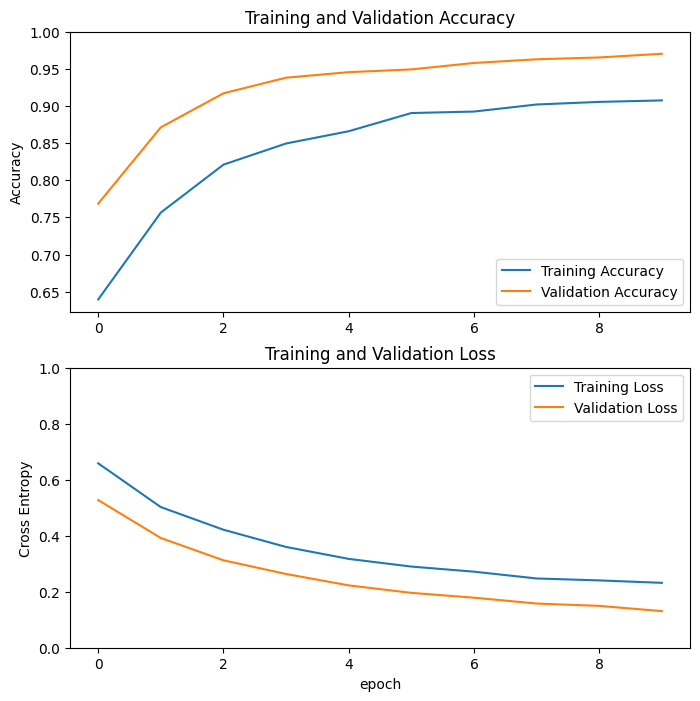

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Fine-Tuning**

##### Un-freeze the top layers of the model

In [127]:
base_model.trainable = True

In [128]:
print("Number of layers in the base model:", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 154


##### Compile the model again

In [131]:
model.compile(optimizer= tf.keras.optimizers.Adam(base_learning_rate),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(threshold= 0.5, name= 'accuracy')])

In [132]:
model.summary(show_trainable= True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_8 (InputLayer)  │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ sequential_5 (Sequential)   │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_160        │ (None, 5, 5, 1280)    │  2,257,984 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_9 (Dense)             │ (None, 1)             │      1,281 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [133]:
len(model.trainable_variables)

56

In [135]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs= total_epochs,
                         initial_epoch= len(history.epoch),
                         validation_data= validation_ds)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 974ms/step - accuracy: 0.8566 - loss: 0.3091 - val_accuracy: 0.9827 - val_loss: 0.0427
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 775ms/step - accuracy: 0.9469 - loss: 0.1361 - val_accuracy: 0.9752 - val_loss: 0.0616
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 804ms/step - accuracy: 0.9367 - loss: 0.1348 - val_accuracy: 0.9814 - val_loss: 0.0529
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 759ms/step - accuracy: 0.9547 - loss: 0.1042 - val_accuracy: 0.9814 - val_loss: 0.0567
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 773ms/step - accuracy: 0.9739 - loss: 0.0735 - val_accuracy: 0.9827 - val_loss: 0.0445
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 895ms/step - accuracy: 0.9701 - loss: 0.0710 - val_accuracy: 0.9777 - val_loss: 0.0609
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 824ms/step - accuracy: 0.9830 - loss: 0.0534 - val_accuracy: 0.9740 - val_loss: 0.1242
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 850ms/step - accuracy: 0.9799 - loss: 0.0639 - 

### **Evaluate and predict on test dataset**

In [136]:
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy:", accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.9965 - loss: 0.0277
Test accuracy: 0.9947916865348816


In [139]:
image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print(predictions[:5])
print(label_batch[:5])

tf.Tensor([1 1 1 1 0], shape=(5,), dtype=int32)
tf.Tensor([1 1 1 1 0], shape=(5,), dtype=int32)


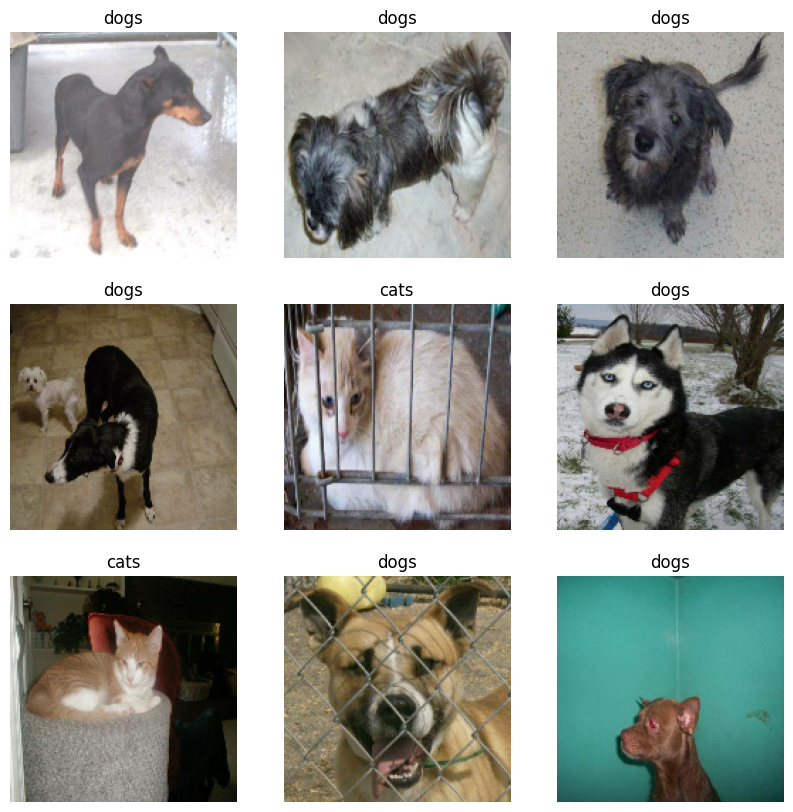

In [140]:
plt.figure(figsize= (10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")